# Image Classification with EfficientNetB0
This notebook trains a grayscale MRI image classifier using transfer learning from EfficientNetB0 and includes data augmentation, class balancing, and performance evaluation.

## Import Required Libraries

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

## Define Paths and Hyperparameters

In [2]:
# Define the paths to the dataset and hyperparameters
DATA_DIR = './dataset_2'
TEST_DIR = './test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

## Set Up Data Generators

In [3]:
# Load Datasets (Grayscale)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="grayscale"
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.
Found 480 files belonging to 4 classes.


In [4]:
# Optimise performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation & Preprocessing

In [5]:
# Data Augmentation (applied during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Load Pre-trained EfficientNetB0

In [6]:
# Load Base Model (EfficientNetB0, pretrained on ImageNet)
# Input shape must have 3 channels, so grayscale images will be broadcast to match
base_model = EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')
base_model.trainable = True  # Fine-tune entire model

## Build the Model

In [7]:
# Assemble full model with classifier on top
model = models.Sequential([
    data_augmentation,
    layers.Lambda(preprocess_input),  # Preprocess for EfficientNet
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Compute class weights to balance class distribution
y_train = np.concatenate([y.numpy() for _, y in train_ds])
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = dict(enumerate(class_weights))

2025-06-16 15:35:02.495091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training the Model

In [9]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3502 - loss: 1.3633 - val_accuracy: 0.3229 - val_loss: 1.3582
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.6614 - loss: 0.9565 - val_accuracy: 0.3646 - val_loss: 1.2172
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7773 - loss: 0.6902 - val_accuracy: 0.3958 - val_loss: 1.0418
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8745 - loss: 0.4931 - val_accuracy: 0.5938 - val_loss: 0.7898
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8714 - loss: 0.4015 - val_accuracy: 0.7396 - val_loss: 0.5989
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9105 - loss: 0.2839 - val_accuracy: 0.7812 - val_loss: 0.5168
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9482 - loss: 0.2148 - val_accuracy: 0.8646 - val_loss: 0.4021
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9562 - loss: 0.1967 - val_accuracy: 0.8854 - val_loss:

## Evaluate the Model

In [10]:
# Predict and evaluate performance
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


2025-06-16 15:38:45.373503: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Classification Report

In [11]:
# Display metrics
print("Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Test Accuracy: 0.8916666666666667

Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.98      0.92       120
  meningioma       0.88      0.72      0.79       120
     notumor       0.90      0.95      0.92       120
   pituitary       0.92      0.91      0.92       120

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480



## Confusion Matrix

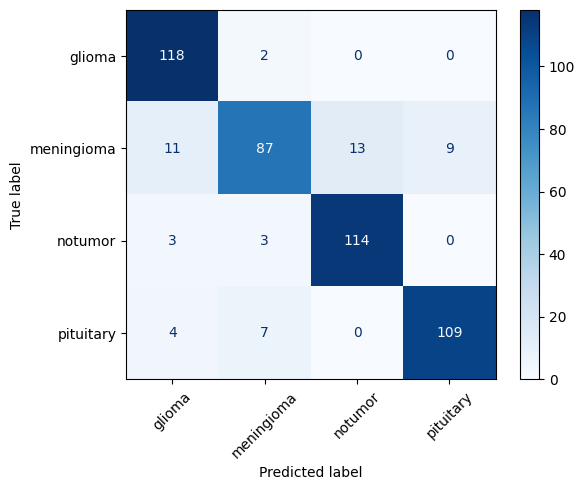

In [12]:
# Generate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

## Saving the model

In [13]:
# Save the trained model
model.save('mri_classifier.keras')